In [9]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from obspy.geodetics import gps2dist_azimuth

path = '/home/sdybing/gnss-picker/cnn_models_outputs/newfault_fq_train/models/traindate_2024-10-01/data/'

data = np.load(path + '2024-10-19gfast_realtest_orig_data.npy')
metadata = np.load(path + 'pgd_realdata_test_metadata_w_hypdist_pgd_snrs.npy')
targets = np.load(path + '2024-10-19gfast_realtest_target.npy')
predictions = np.load(path + '2024-10-19gfast_realtest_predictions.npy')

num_realtest = len(predictions)
thresholds = np.arange(0, 1.005, 0.005)
test_thresholds = [0, 0.005]

In [11]:
# for i in range(len(data)):
#     ax = plt.subplot(111)
#     ax.plot(data[i])
#     ax2 = ax.twinx()
#     ax2.plot(targets[i], color = 'black')
#     ax2.plot(predictions[i], color = 'red')
#     ax2.set_ylim(0,1)
#     plt.show()

In [12]:
accuracies = []
precisions = []
recalls = []
F1s = []

for ind in range(len(thresholds)):
    
    threshold = np.round(thresholds[ind],3)
    
    print('-------------------------------------------------------------')
    print('Threshold: ' + str(threshold))
    
    iterate = np.arange(0,num_realtest,1)
    
    # Convert the prediction arrays to 1s and 0s if the prediction Gaussian exceeded the threshold or not
        
    pred_binary = np.zeros(len(predictions)) # Initialize the array with all zeros
    for k in iterate:
#         plt.plot(fqtest_predictions[k]) # The output "Gaussian" or straight line prediction
#         plt.ylim(0,1)
#         plt.show()
        i = np.where(predictions[k] >= threshold)[0]
        if len(i) == 0: 
            pred_binary[k] = 0
        elif len(i) > 0: # If anywhere in the prediction the Gaussian exceeds the threadshold, add a 1 to the pred_binary array for this prediction
            pred_binary[k] = 1
#     print('Predictions: ')
#     print(pred_binary) 
    
    # Convert the target arrays to 1s and 0s if the Gaussian exceeded the threshold or not (signal or noise)
    
    targ_binary = np.zeros(len(targets))
    for k in iterate:
        i = np.where(targets[k] > 0)[0]
        if len(i) == 0:
            targ_binary[k] = 0
        elif len(i) > 0:
            targ_binary[k] = 1
#     print('Targets: ')
#     print(targ_binary)
    
    # Calculating the accuracy, precision, recall, and F1
    
    num_preds = num_realtest # Total number of predictions
    correct_preds = []
    wrong_preds = []
    true_pos = []
    true_neg = []
    false_pos = []
    false_neg = []
    
    for i in iterate:
        
        pred = pred_binary[i]
        targ = targ_binary[i]
        
        if pred == targ: # Add one to list of correct predictions if matching
            correct_preds.append(1)
            
            if pred == 1 and targ == 1: # True positive: there is an earthquake, and the model found it
                true_pos.append(1)
            elif pred == 0 and targ == 0: # True negative: there isn't an earthquake, and the model found just noise
                true_neg.append(1)
            
        elif pred != targ: # Add ones to list of incorrect predictions if not matching
            wrong_preds.append(1)
            
            if pred == 1 and targ == 0: # False positive: there isn't an earthquake, and the model thought it found one
                false_pos.append(1)
            elif pred == 0 and targ == 1: # False negative: there is an earthquake, and the model missed it
                false_neg.append(1)
    
    num_correct_preds = len(correct_preds)
    num_wrong_preds = len(wrong_preds)
    num_true_pos = len(true_pos)
    num_true_neg = len(true_neg)
    num_false_pos = len(false_pos)
    num_false_neg = len(false_neg)
    
    # print('Threshold: ' + str(threshold))
    # print('Correct preds: ' + str(num_correct_preds))
    # print('Wrong preds: ' + str(num_wrong_preds))
    # print('True pos: ' + str(num_true_pos))
    # print('True neg: ' + str(num_true_neg))
    # print('False pos: ' + str(num_false_pos))
    # print('False neg: ' + str(num_false_neg))
    
    accuracy = num_correct_preds / num_preds
    accuracy_per = (num_correct_preds / num_preds) * 100
    print('Accuracy: ' + str(accuracy_per) + '%')
    
    if num_true_pos == 0  and num_false_pos == 0:
        precision = 0
    else:
        precision = num_true_pos / (num_true_pos + num_false_pos)
    
    if num_true_pos == 0 and num_false_neg == 0:
        recall = 0
    else:
        recall = num_true_pos / (num_true_pos + num_false_neg)
    
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2 * ((precision * recall) / (precision + recall))
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(F1)

# print('Accuracies')
# print(accuracies)
# print('Precisions')
# print(precisions)
# print('Recalls')
# print(recalls)
# print('F1s')
# print(F1s)


-------------------------------------------------------------
Threshold: 0.0
Accuracy: 100.0%
-------------------------------------------------------------
Threshold: 0.005
Accuracy: 100.0%
-------------------------------------------------------------
Threshold: 0.01
Accuracy: 100.0%
-------------------------------------------------------------
Threshold: 0.015
Accuracy: 100.0%
-------------------------------------------------------------
Threshold: 0.02
Accuracy: 100.0%
-------------------------------------------------------------
Threshold: 0.025
Accuracy: 100.0%
-------------------------------------------------------------
Threshold: 0.03
Accuracy: 98.2094897045658%
-------------------------------------------------------------
Threshold: 0.035
Accuracy: 82.54252461951657%
-------------------------------------------------------------
Threshold: 0.04
Accuracy: 53.745150701283194%
-------------------------------------------------------------
Threshold: 0.045
Accuracy: 31.75171590569979

In [13]:
np.save(path + 'gfast_realdata_test_thresholds.npy', thresholds)
np.save(path + 'gfast_realdata_test_accuracies.npy', accuracies)
np.save(path + 'gfast_realdata_test_precisions.npy', precisions)
np.save(path + 'gfast_realdata_test_recalls.npy', recalls)
np.save(path + 'gfast_realdata_test_F1s.npy', F1s)

In [14]:
# Find threshold with highest accuracy

acc0 = 0

for idx in range(len(accuracies)):
    acc = accuracies[idx]
    if acc > acc0:
        acc0 = acc
        best_thresh = thresholds[idx] # Only updates when it hits a higher accuracy
        
print(best_thresh)

0.0


In [15]:
best_thresh = 0.135

In [16]:
thresholds = np.load(path + 'gfast_realdata_test_thresholds.npy')
accuracies = np.load(path + 'gfast_realdata_test_accuracies.npy')
precisions = np.load(path + 'gfast_realdata_test_precisions.npy')
recalls = np.load(path + 'gfast_realdata_test_recalls.npy')
F1s = np.load(path + 'gfast_realdata_test_F1s.npy')

In [17]:
r = np.where(thresholds == 0.135)[0]
print(accuracies[r])

[0.0325276]


In [18]:
e = np.where(precisions == np.max(precisions))[0]
print(np.max(precisions))
print(thresholds[e])
print(accuracies[e])

1.0
[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295
 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355
 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415
 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475
 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535
 0.54  0.545 0.55  0.555 0.56  0.565 0.57  0.575 0.58  0.585 0.59  0.595
 0.6   0.605 0.61  0.615 0.62  0.625 0.63  0.635 0.64  0.645 0.65  0.655
 0.66  0.665 0.67  0.675 0.68  0.685 0.69  0.695 0.7   0.705 0.71  0.715
 0.72  0.725 0.73  0.735 0.74  0.745 0.75  0.755 0.76  0.765 0.77  0.775
 0.78  0.785 0.79  0.795 0.8   0.805 0.81  0.81

In [19]:
e = np.where(recalls == np.max(recalls))[0]
print(np.max(recalls))
print(thresholds[e])
print(accuracies[e])

1.0
[0.    0.005 0.01  0.015 0.02  0.025]
[1. 1. 1. 1. 1. 1.]


In [20]:
e = np.where(F1s == np.max(F1s))[0]
print(np.max(F1s))
print(thresholds[e])
print(accuracies[e])

1.0
[0.    0.005 0.01  0.015 0.02  0.025]
[1. 1. 1. 1. 1. 1.]


In [21]:
# Subplot version

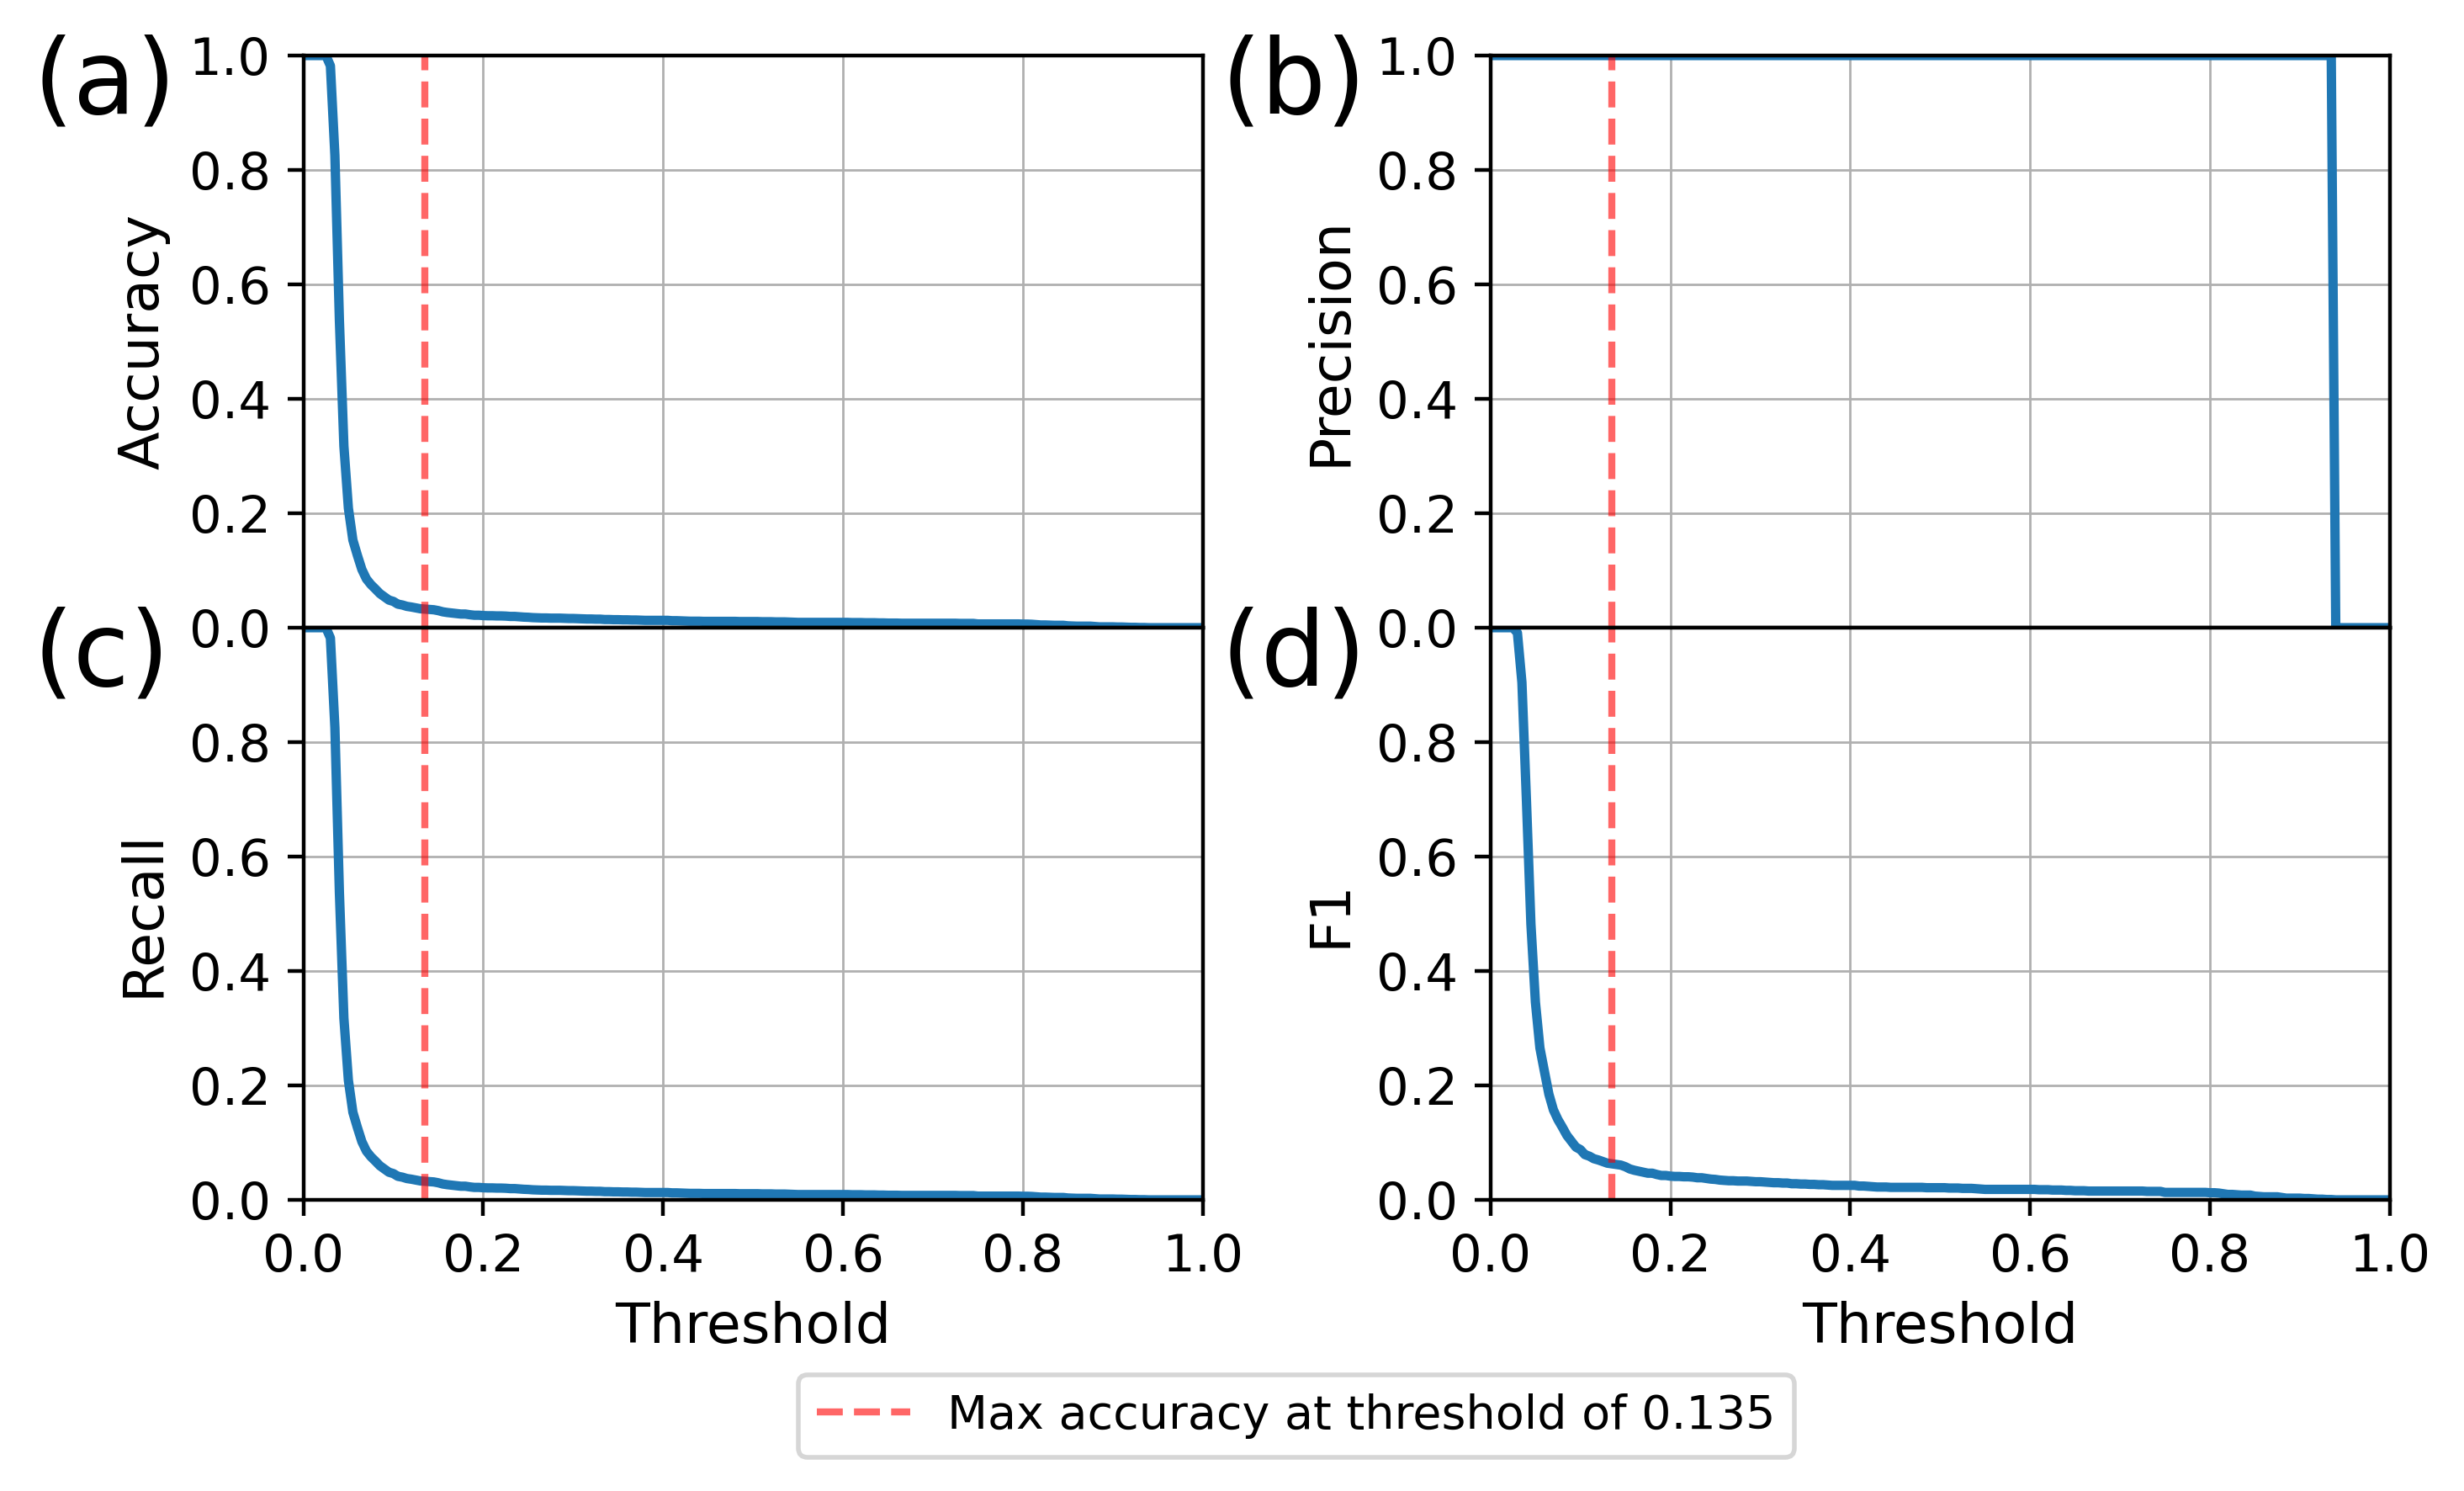

In [22]:
plt.figure(figsize = (8,5), dpi = 400)

plt.subplot(221)
plt.text(x = -0.3, y = 0.9, s = '(a)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, accuracies, linewidth = 2)
plt.ylabel('Accuracy', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6, label = 'Max accuracy at threshold of ' + str(best_thresh))
plt.tick_params(axis = 'both', bottom = False, labelbottom = False)
plt.yticks(fontsize = 11)
plt.legend(loc = (0.55,-1.45))

# plt.legend()

plt.subplot(222)
plt.text(x = -0.3, y = 0.9, s = '(b)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, precisions, linewidth = 2)
plt.ylabel('Precision', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.tick_params(axis = 'both', bottom = False, labelbottom = False)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6)
plt.yticks(fontsize = 11)


plt.subplot(223)
plt.text(x = -0.3, y = 0.9, s = '(c)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, recalls, linewidth = 2)
plt.xlabel('Threshold', fontsize = 12)
plt.ylabel('Recall', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize = 11)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], fontsize = 11)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6)

plt.subplot(224)
plt.text(x = -0.3, y = 0.9, s = '(d)', fontsize = 22)
plt.grid(lw = 0.5, zorder = 0)
plt.plot(thresholds, F1s, linewidth = 2)
plt.xlabel('Threshold', fontsize = 12)
plt.ylabel('F1', fontsize = 12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(fontsize = 11)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], fontsize = 11)
plt.axvline(best_thresh, color = 'red', linestyle = '--', alpha = 0.6)

plt.subplots_adjust(hspace = 0, wspace = 0.32, bottom = 0.2)

plt.show()

# plt.savefig('/home/sdybing/gnss-picker/manuscript_figures/fq_testdata_classification.jpg', format = 'JPG')
# plt.close();